# Segmentation with derivatives

Here I am trying to find contours for each grain using technique explained in [Mastering OpenCV with practical computer vision projects](https://www.amazon.com/Mastering-OpenCV-Practical-Computer-Projects-ebook/dp/B00AHCJNDG), p. 167-168 used for car plates segmentation. 

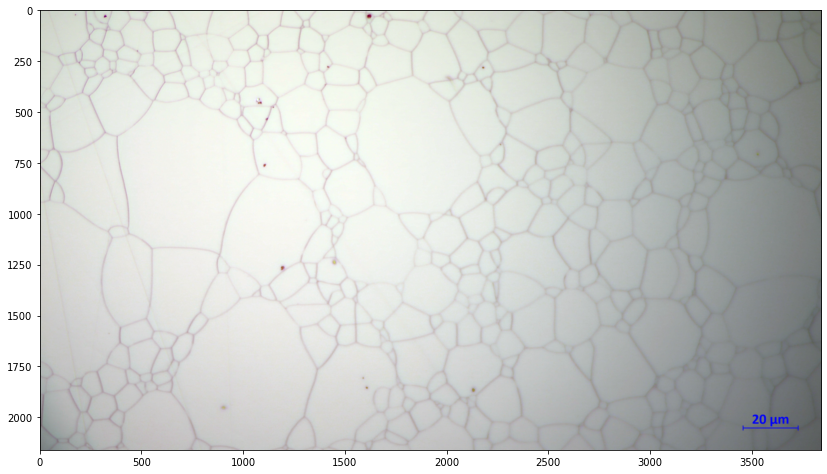

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 9]

img = cv2.imread('../example_data/Snap-05.jpg')
plt.imshow(img)
plt.show()

## Greyscale
We don't need colors information to find contours.

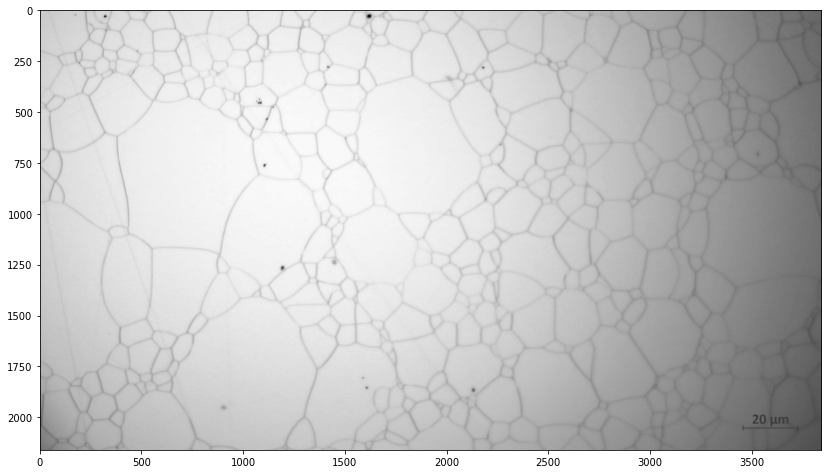

In [2]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')
plt.show()

## Histogram normalization
The grayscale image seems to have poor contrast of cluster lines. You can see this on image historgram:

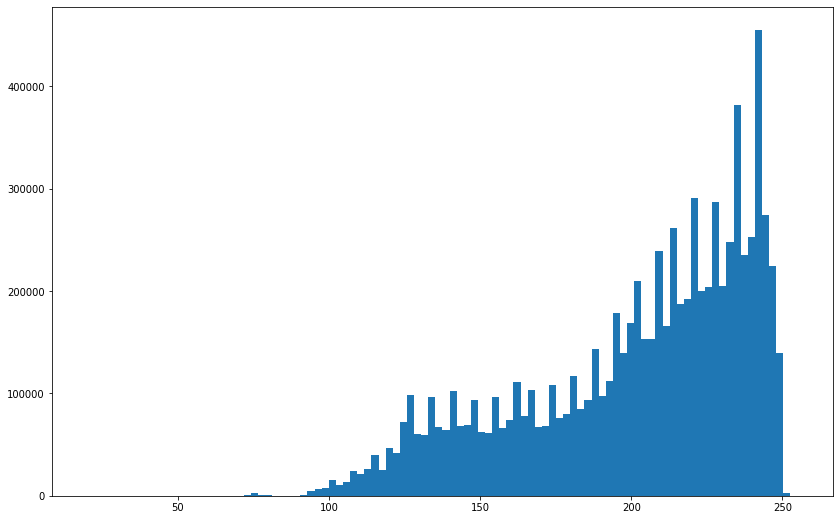

In [9]:
plt.hist(img_gray.flatten(), bins=100)
plt.show()

[Adaptive histogram equalization](https://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html) can help with this:

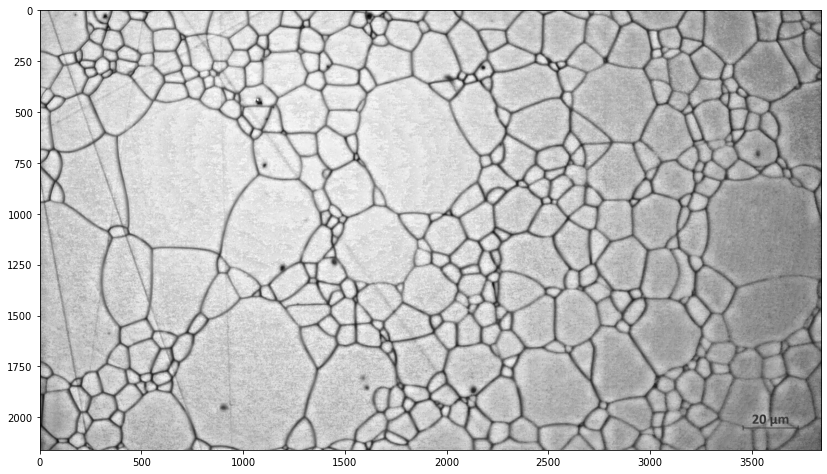

In [10]:
clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(64, 64))
img_cl = clahe.apply(img_gray)
plt.imshow(img_cl, cmap='gray')
plt.show()

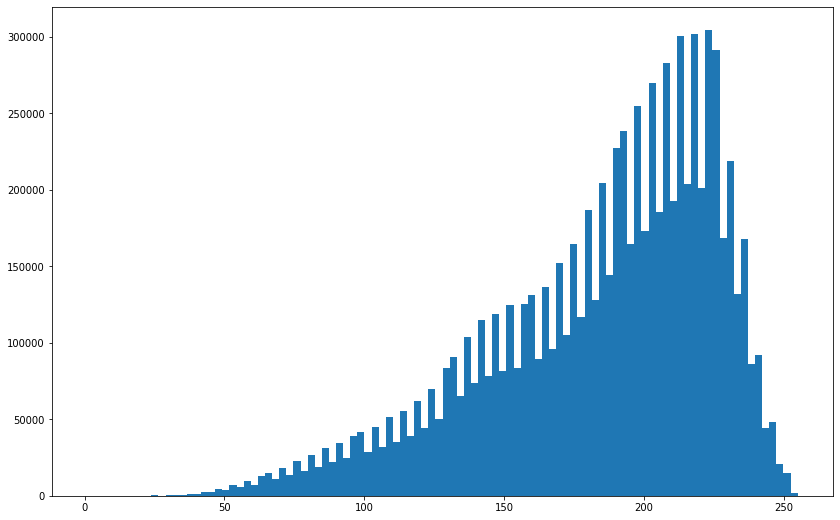

In [11]:
plt.hist(img_cl.flatten(), bins=100)
plt.show()

## Blurring
The image have ambient noise which can be removed using Gaussian filter, e.g. blur.


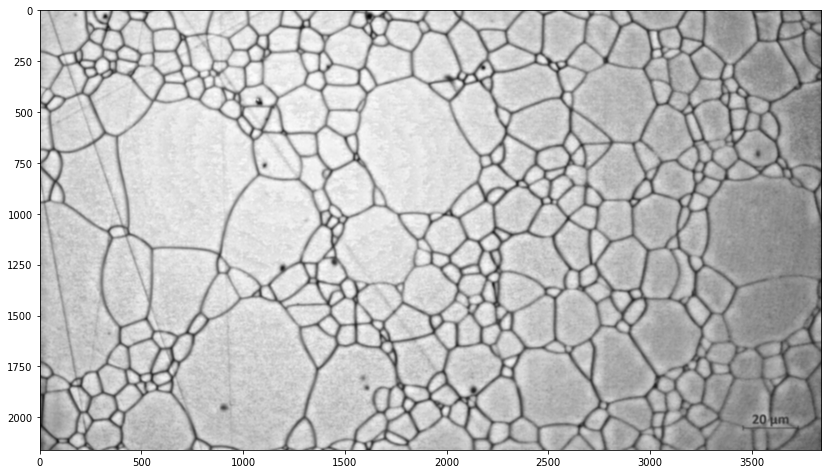

In [12]:
img_bl = cv2.blur(img_cl, (10, 10))
plt.imshow(img_bl, cmap='gray')
plt.show()

## Derivatives
Sobel filter creates a derivative of a 2d image. Here instead of deriving dxdy altogether, I calculate partial derivatives for dx and dy and merge them.

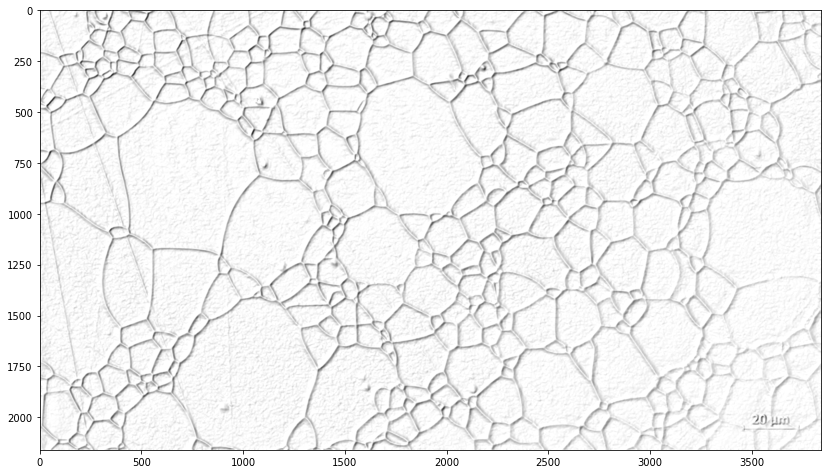

In [14]:
img_deriv_x = cv2.Sobel(img_bl, cv2.CV_8U, 1, 0)
img_deriv_y = cv2.Sobel(img_bl, cv2.CV_8U, 0, 1)
img_deriv = cv2.addWeighted(img_deriv_x, 0.5, img_deriv_y, 0.5, 0.0)
plt.imshow(img_deriv, cmap='gray_r')
plt.show()

## Binarization
Contours fitting can only be applied to binary images, therefore we have to [threshold images](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html).

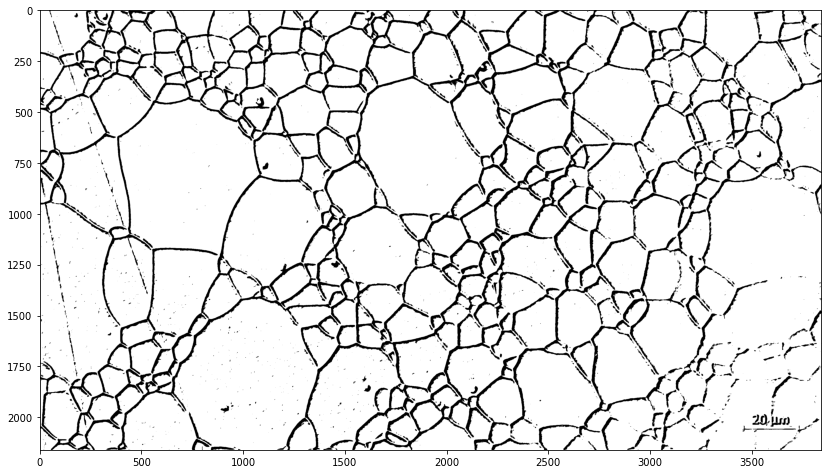

In [20]:
_, img_tr = cv2.threshold(img_deriv, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY)
plt.imshow(img_tr, cmap='gray_r')
plt.show()

## Contours

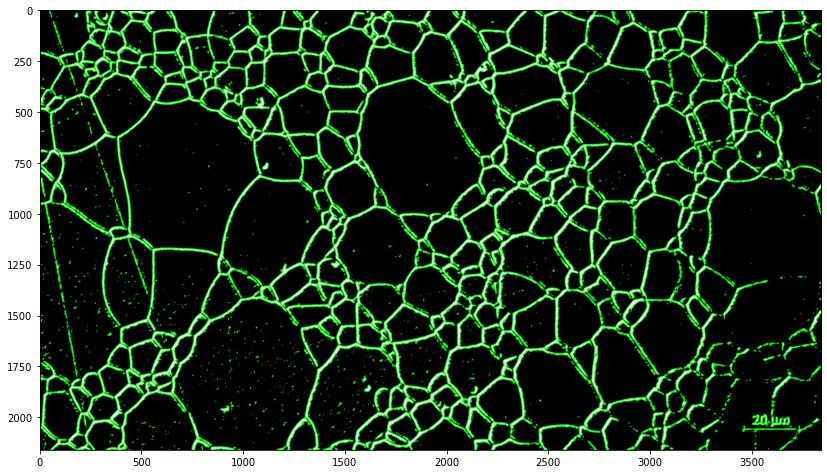

In [21]:
contours, hierarchy = cv2.findContours(img_tr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_tr2 = cv2.cvtColor(img_tr, cv2.COLOR_GRAY2BGR)
img_contours = cv2.drawContours(img_tr2, contours, -1, (0,255,0), 3)
plt.imshow(img_contours)
plt.show()

In [22]:
import pandas as pd

length_distribution = pd.Series(list(map(len, contours)))
ind = length_distribution[length_distribution > 50].index
long_contours = [contours[i] for i in ind]
len(long_contours)

242

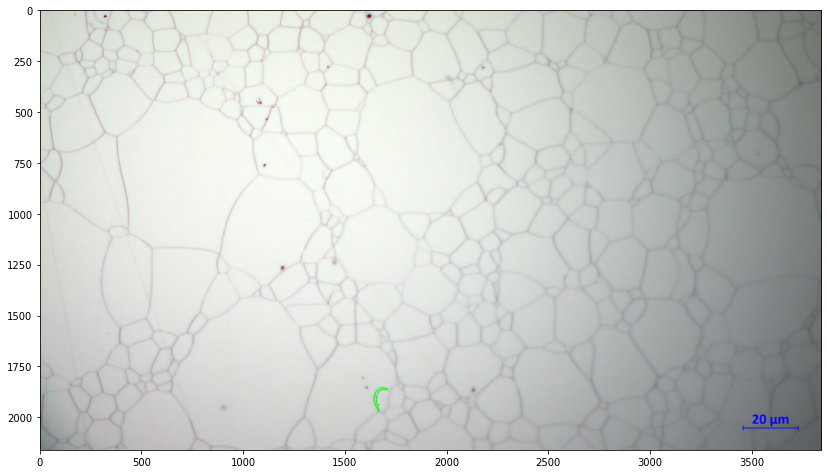

In [114]:
img_tr2 = cv2.cvtColor(img_tr, cv2.COLOR_GRAY2BGR)
img_c = img.copy()
img_contours = cv2.drawContours(img_c, long_contours, 30, (0,255,0), 3)
plt.imshow(img_contours)
plt.show()

The main problem of that approach is that derivatives creates new contours. When we calculate a derivative of a simple line like:

    0 0 1 1 0 0
    0 0 1 1 0 0
    0 0 1 1 0 0 
    0 0 1 1 0 0 

Derivative create a shape around this line:

    0 1 0 1 0 0
    0 1 0 1 0 0
    0 1 0 1 0 0
    0 1 0 1 0 0
    
Therefore countours are drawn around lines instead of being drawn around grains, bounded by lines.